In [4]:
# Importing packages
from time import time
#from cupyx.time import repeat
import numpy as np
#import cupy as cp
from numba import njit
import ruptures as rpt
from pychange.numba_costs import normal_mean_var_cost as aot_normal_mean_var_cost
from pychange.numba_costs import scalar_normal_mean_var_cost as aot_scalar_normal_mean_var_cost
#from pychange.gpu.costs import normal_mean_var_cost as gpu_normal_mean_var_cost
#from pychange.gpu.preprocess import create_summary_stats as gpu_create_summary_stats
#from pychange.gpu.segment import pelt as gpu_pelt
from pychange.costs import normal_mean_var_cost, ParametricCost
from pychange.segment import create_summary_stats, pelt
import matplotlib.pyplot as plt

# import rpy2's package module
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects

# import R's utility package
utils = rpackages.importr('utils')
rcp = rpackages.importr('changepoint')

In [89]:
# Creating test data with random normal
#n_total = np.logspace(1.5, 3.5, num=5)
def make_test_series(series_length=100, n_series=20):
    
    
    return np.hstack([np.random.poisson(np.random.uniform(0, 20, size=(1,))[0],
                                       #np.random.uniform(1e-2, 20, size=(1,))[0],
                                       (series_length,)) for _ in range(n_series)])
test_series = make_test_series()
r_series = robjects.FloatVector(np.array(test_series))

In [90]:
# Storing results
results = {'r': [], 'ruptures': [], 'pychange': [], 'pychange_aot': []}

In [91]:
# Jitting sum stats
jit_sum_stats = njit(fastmath=True)(create_summary_stats)
sum_stats = jit_sum_stats(test_series)

# Jitting cost function
jit_normal_mean_var_cost = njit(fastmath=True)(normal_mean_var_cost)
_ = jit_normal_mean_var_cost(sum_stats)

# Jitting segmentation function
jit_pelt = njit(fastmath=True)(pelt)
_ = jit_pelt(test_series, 30, 100, jit_sum_stats, jit_normal_mean_var_cost)

In [92]:
# Pychange
results['pychange'] = jit_pelt(test_series, 30, 100, jit_sum_stats, jit_normal_mean_var_cost)

In [101]:
# R changepoint benchmark
results['r'] = np.array(rcp.cpts(rcp.cpt_meanvar(r_series, penalty="Manual", pen_value=100, method='PELT', test_stat='Normal')))

In [94]:
# Ruptures
results['ruptures'] = rpt.Pelt(custom_cost=ParametricCost(cost_fn=aot_scalar_normal_mean_var_cost)).fit(test_series).predict(pen=100)

In [95]:
# Evaluation metrics
from ruptures.metrics import precision_recall
from ruptures.metrics import hausdorff
from ruptures.metrics import randindex

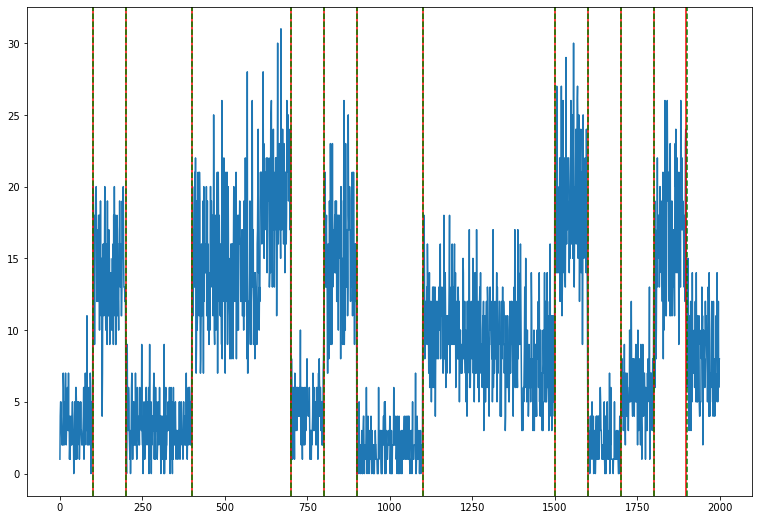

In [96]:
plt.figure(figsize=(13, 9))
plt.plot(test_series)
for i in results['r']:
    plt.axvline(i, color='red')
for i in results['ruptures'][:-1]:
    plt.axvline(i, color='green', linestyle='--')
plt.show()

In [102]:
y = [i * 100 for i in range(1, 21)]
results['r'] = list(np.append(results['r'], [20 * 100]))

In [103]:
print('Precision')
print('R:', precision_recall(y, results['r']))
print('Ruptures:', precision_recall(y, results['ruptures']))

Precision
R: (1.0, 0.631578947368421)
Ruptures: (1.0, 0.631578947368421)


In [104]:
print('Hausdorff')
print('R:', hausdorff(y, results['r']))
print('Ruptures:', hausdorff(y, results['ruptures']))

Hausdorff
R: 200.0
Ruptures: 200.0


In [105]:
print('Rand Index')
print('R:', randindex(y, results['r']))
print('Ruptures:', randindex(y, results['ruptures']))
print('R & Ruptures:', randindex(results['r'], results['ruptures']))
# https://arxiv.org/abs/2003.06222

Rand Index
R: 0.944801
Ruptures: 0.945
R & Ruptures: 0.999801
